# Guide to Creating Heterostructures and Running the Workflow

This notebook shows how the hetero_interfaces function operates, providing reasonable starting values for each variable. We demonstrate how to use the workflow get_heterostructure_stabilityWF in order to determine the thermodynamic stability of a 2D-substrate hetero-interfacial structure. Finally, the notebook also illustrates how to query the database for various fields.

Author & Maintainer: Tara M. Boland

Email: tboland1@asu.edu

If you like jupyter notebooks, I recommend checking out jupyter_contrib_nbextensions (install via pip). 

In [1]:
# import libs
import json, pickle
import matplotlib as mpl, matplotlib.pyplot as plt, pandas as pd
import seaborn as sns, numpy as np
%matplotlib inline

# structure manipuations libs
from pymatgen import Structure, Composition
from pymatgen.core.surface import Slab, SlabGenerator
from pymatgen.analysis.structure_analyzer import SpacegroupAnalyzer
from pymatgen.transformations.advanced_transformations import SlabTransformation

# workflow libs
from hetero2d.manipulate.heterotransmuter import hetero_interfaces
from hetero2d.manipulate.utils import show_struct_ase

In [13]:
# import example data structures
filename = 'example_structs.pkl'
with open(filename, 'rb') as p:
    struct_2d, struct_3d2d, struct_bulk, struct_sub = pickle.load(p)

## If you got an error running the first cell :)

Ensure you have installed the Hetero2d repository from github.

If you encounter an error running the first cell block follow the steps below to try to fix common errors.

1.  A missing environment kernel. You should have the *Hetero2d* environment kernel option under the *Change Kernel* tab under the *Kernel* drop down menu. If you do not have this option you need to configure conda to find the environment kernels. 
    1. Activate your Hetero2d environment in the command prompt 
    2. Copy and paste the code below to add the kernel to the conda
        * `python -m ipykernel install --user --name=Env (Hetero2d)` 
    3. Restart jupyter notebook.

2. Not adding Hetero2d to your python path. 
     1. In your .bashrc file add `export PYTHONPATH="$HOME/path/to/Hetero2d/:$PYTHONPATH"` and restart this notebook.

## Importing Structures from Outside Databases (Optional)

This section requires you to have a copy of c2db.db (highly recommend getting this) and an API key for Materials Project. 
* https://cmr.fysik.dtu.dk/c2db/c2db.html
* https://materialsproject.org/#search/materials

In [2]:
# import search libs
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.ext.matproj import MPRester
import ase.db

/home/tboland1/anaconda3/envs/cms/lib/python3.6/site-packages/pymatgen/__init__.py:35: UserWarning: With effect from pmg 5.0, all pymatgen settings are prefixed with a "PMG_". E.g., "PMG_VASP_PSP_DIR" instead of "VASP_PSP_DIR".
  warnings.warn('With effect from pmg 5.0, all pymatgen settings are'


In [3]:
# 2D: c2db access database (Grab 2d MoS2 from c2db)
db = ase.db.connect('/path/to/file/c2db.db')
# Get all MoS2 phases from C2DB
formula = 'MoS2'
mos2 = db.select('formula=MoS2')

mos2_phases = {}
for row in mos2:
    proto = row['prototype']
    ase_2d = db.get_atoms(formula=formula,prototype=proto) 
    struct_mos2 = AseAtomsAdaptor.get_structure(atoms=ase_2d)
    mos2_phases[proto] = struct_mos2
struct_2d = mos2_phases['MoS2']

In [3]:
# search Materials Project for 3D form of 2D material (bulk MoS2)
mpr = MPRester()
struct_3d2d = mpr.get_structure_by_material_id('mp-1018809')

In [5]:
# search Materials Project for substrate (bulk Zr)
struct_bulk = mpr.get_structure_by_material_id('mp-8635')

# Creating hetero-interface structures

In [7]:
# heterointerfaces module input values
max_area, max_mismatch = 80, 0.05
max_angle_diff, separation = 1, 3
r1r2_tol, nlayers_2d = 0.01, 3
nlayers_sub = 1

In [8]:
# slab generation params
lll_reduce, max_normal_search, center_slab, primitive = True, True, True, True
in_unit_planes = False
min_vacuum_size, min_slab_size, shift, tol = 18, 12, 0, 0.1

In [11]:
# Create 111 substrate surfaces
miller_index = [1,1,1]
struct = SpacegroupAnalyzer(struct_bulk).get_conventional_standard_structure()
st = SlabTransformation(miller_index, min_slab_size, min_vacuum_size, lll_reduce, 
            center_slab, in_unit_planes, primitive, max_normal_search, shift, tol)
struct_slab = st.apply_transformation(struct)

In [14]:
# create heterointerface structs & store structs in iface_out
iface_out = hetero_interfaces(struct_2d, struct_sub, max_mismatch, max_area, nlayers_2d, nlayers_sub, 
            r1r2_tol, max_angle_diff, separation)

rmax1, rmax2: 9, 9


MATCH FOUND

u,v & angle mismatches:
-0.0008767653502491646, -0.0008769404292973126, 4.932076819841313e-06



In [10]:
alignment_params = iface_out.pop(-1)
print(alignment_params)

{'opt_uv1': [array([3.19595400e+00, 0.00000000e+00, 1.95695742e-16]), array([ 0.00000000e+00, -5.53555600e+00, -5.87087294e-16])], 'opt_uv2': [array([3.18406646e+00, 0.00000000e+00, 1.94967840e-16]), array([ 1.77635684e-15, -5.51496489e+00, -5.84903521e-16])], 'u': -0.0037195577018340753, 'v': -0.003719790476344631, 'angle': 1.4210854715202004e-14, 'tm1': array([[1, 0],
       [1, 2]]), 'tm2': array([[ 1,  0],
       [-1, -2]]), 'fu_2d': 2.0, 'fu_sub': 2.0}


In [15]:
# this line is likely not to work if you are running the notebook
# on a remote server
show_struct_ase(iface_out[0])

# Running Heterostructure Workflow

In [16]:
# required variables and python libraries
from hetero2d.workflow import get_heterostructures_stabilityWF
from hetero2d.io.VaspInterfaceSet import CMDLInterfaceSet
from fireworks import LaunchPad

### Set up Mongo Database Information 

In [ ]:
host = 'mongo_db_ip_address'
port = # port number for database
authsource = 'authentication database'
name = 'database_name'
username = 'your_username'
password = 'database_password'

## Setting up get_heterostructure_stabilityWF
This example shows how to set up the WF when the 2d, 3d2d, bulk, and substrate slab have not previously been relaxed.

The user must always provide the workflow with the path the vasp executable.

The parameter *bin_2d* allows the user to supply the path to an executable for VASP compiled to prevent the 2D material's vacuum spacing from shrinking. 

In [10]:
# set the path to the 2D and 3D vasp version
bin_2d = 'srun --mpi=pmi2 /path/to/remote/vasp_std_2D' 
bin_3d = 'srun --mpi=pmi2 /path/to/remote/vasp_std_3D' 

Should the user want to override one of the default VASP parameters in the *CMDLInterfaceSet* for every firework in the workflow you can add it to the *uis*.  

If you want to change a VASP parameter for an individual firework in the workflow you can use:
* uis_2d : custom INCAR settings for 2D firework
* uis_3d2d : custom INCAR settings for 3D2D firework
* uis_bulk : custom INCAR settings for bulk firework
* uis_trans : custom INCAR settings for substrate surface firework
* uis_iface : custom INCAR settings for heterointerface fireworks

In [11]:
uis = dict(EDIFF  = 0.0001, EDIFFG = -0.05, IBRION = 2,
    POTIM = 0.15, ISPIN = 1, NSW = 500, NELMDL = -6)

The parameter *slab_params* is used to create the substrate surface slab within the Firework from a bulk structure. The input parameters are the same as the pymatgen *SlabTransformation* input parameters.

In [12]:
slab_params = {'transformations': ['SlabTransformation'],
    'transformation_params': [{'miller_index': [1,1,1], 
        'lll_reduce': True, 'max_normal_search': True, 
        'min_vacuum_size': 18, 'primitive': False, 
        'min_slab_size': 12, 'center_slab': True}]}

The parameter *heterotransformation_params* is used to create the hetero-interface structures subject to the constraints listed below.

In [13]:
heterotransformation_params=[{'max_mismatch': 0.05, 
    'max_area': 100, 'max_angle_diff': 1, 'r1r2_tol': 0.1, 
    'nlayers_2d': 3, 'nlayers_sub': 2, 'separation': 3}]

The parameter *user_additions* is used to configure the spec file for all the fireworks in the workflow. The minimum required parameters to supply is listed below. 

The *unique_id* is appended to each firework to track fireworks in the workflow in the database.

*analysis_info* is used to supply energetic information to fireworks in the workflow to determine the stability of the hetero-structure.

*orient* is the miller index of the substrate surface.

In [14]:
user_additions = {'unique_id': 1, 'analysis_info': [{}],
    'orient': [1,1,1]}

In [15]:
wf = get_heterostructures_stabilityWF(struct_2d, struct_bulk, 
    struct_3d2d, heterotransformation_params, slab_params, 
    user_additions, bin_2d=bin_2d, bin_3d=bin_3d, uis=uis)

Workflow Name: MoS2-on-Zr: hkl-[111]: 1
{-1: [-2], -2: [-5], -3: [-5, -4], -4: [-5], -5: []}


In [12]:
# send the wf to the launch pad
lp = LaunchPad(host=host, port=port, name=name,
               username=username, password=password)

In [13]:
lp.add_wf(wf)

2021-09-02 19:32:50,234 INFO Added a workflow. id_map: {-5: 25, -4: 26, -3: 27, -2: 28, -1: 29}


{-5: 25, -4: 26, -3: 27, -2: 28, -1: 29}

Be sure to read the FireWorks and atomate documentation to learn how to run workflows. 

Some critical features of this workflow only work when jobs are launched using `qlaunch -r rapidfire -m #`. The -m places a limit on the total number of jobs in the queue while -r launches in reservation mode. 

## Setting up get_heterostructure_stabilityWF
This example shows how to set up the WF when the 2d, 3d2d, and bulk structures have previously been relaxed and the substrate slab has not previously been relaxed.

In [16]:
# previously introduced parameters
bin_2d = 'srun --mpi=pmi2 /path/to/remote/vasp_std_2D' 
bin_3d = 'srun --mpi=pmi2 /path/to/remote/vasp_std_3D' 

struct_bulk = SpacegroupAnalyzer(struct_bulk
                ).get_conventional_standard_structure()

uis = dict(EDIFF  = 0.0001, EDIFFG = -0.05, IBRION = 2,
    POTIM = 0.15, ISPIN = 1, NSW = 500, NELMDL = -6)
slab_params = {'transformations': ['SlabTransformation'],
    'transformation_params': [{'miller_index': [1,1,1], 
        'lll_reduce': True, 'max_normal_search': True, 
        'min_vacuum_size': 18, 'primitive': False, 
        'min_slab_size': 12, 'center_slab': True}]}
heterotransformation_params=[{'max_mismatch': 0.05, 
    'max_area': 100, 'max_angle_diff': 1, 'r1r2_tol': 0.1, 
    'nlayers_2d': 3, 'nlayers_sub': 2, 'separation': 3}]

If you have a previously relaxed 2d, 3d2d, and bulk structure you can skip re-optimization of these structures by providing the energies to perform energetic analysis and setting the flags *is_i_optimized* for each firework to True in the *user_additions*.

In [17]:
analysis_info=[{'E_2d':   -19.61627018, 'N_2d':   3, 
                'E_3d2d': -39.66681368, 'N_3d2d': 6}]

In [18]:
user_additions = {'unique_id': 1, 'analysis_info': analysis_info,
    'orient': [1,1,1], 'is_2d_optimized': True, 
    'is_3d2d_optimized': True, 'is_bulk_optimized': True}

In [19]:
wf = get_heterostructures_stabilityWF(struct_2d, struct_bulk, 
    struct_3d2d, heterotransformation_params, slab_params, 
    user_additions, bin_2d=bin_2d, bin_3d=bin_3d, uis=uis)

Workflow Name: MoS2-on-Sr: hkl-[111]: 1
{-6: [-7], -7: []}


In [ ]:
# send the wf to the launch pad
lp = LaunchPad(host=host, port=port, name=name,
               username=username, password=password)

In [ ]:
lp.add_wf(wf)

## Parameters Influencing the Workflow Executation
Below is a list of the input parameters you can provide to the workflow to:
* add additional data to each firework
* skip certain fireworks to relax and store data
* change default behavior of respective fireworks

### get_heterostructure_stabilityWF

By default dipole corrections are turned on and should be left on unless you are sure you they are causing issues.

* dipole = True (Default) To turn off, set to False

If you wish to provide your own VASP Input Set to the workflow you can use the following variables:
* vis_2d : custom Input Set settings for 2D firework
* vis_3d2d : custom Input Set settings for 3D2D firework
* vis_bulk : custom Input Set settings for Bulk firework
* vis_trans : custom Input Set settings for Substrate firework
* vis_iface : custom Input Set settings for 2dOnSubstrate firework

### *user_additions*

The following dictionary keys when specified in the *user_additions* dictionary allow the user to skip:

1) the fireworks to optimize the 2d, 3d2d, bulk, or substrate fireworks

or 

2) to skip analysis for Formation_Energy, Binding_Energy, and Adsorption_Energy

Relaxation tags:
* is_2d_optimized: True - to perform the 2d optimization; False skip optimization
* is_sub_optimized: True - to perform the sub optimization; False skip optimization 
* is_3d2d_optimized: True - to perform the 3d2d optimization; False skip optimization
* is_bulk_optimized: True - to perform the Bulk optimization; False skip optimization

Analysis:
* Binding_Energy: True - to perform analysis of binding energy
* Formation_Energy: True - to perform analysis of formation energy
* Adsorption_Energy: True - to perform analysis of adsorption energy

Calculation & computing parameters:
* vdw: 'optB88' - set the type of functional to be used in the calculations
* _preserve_fworker: True - ensure that once a calculation starts on one computing resource that all other jobs will run on the same computing resource.
* duplicate: True - perform duplicate checking for duplicated workflows (very restrictive matching)

Hetero-interface computing resource parameters:
* wall_time_hetero: "hr:mm:ss" - the wall time to set for the hetero-interface calculation 
* iface_nodes: 1 (default) - set the number of nodes to use in relaxing the hetero-structures
* ntasks: # (no default) - set the number of cpu cores to use in relaxing the hetero-structures
* any valid key to be used in _queueadapter settings is valid for the hetero-interface 

Substrate Slab Computing Resource Parameters:
* sub_nodes: 1 (default) - set the number of nodes to use in relaxing the substrate slab

In [ ]:
# example user additions dictionary
user_additions = {'unique_id': 1, 'duplicate': True,
    'vdw': 'optB88', 'is_bulk_optimized': False,
    'is_sub_optimized': False, 'is_2d_optimized': False, 
    'is_3d2d_optimized': False, 'orient': [1,1,1], 'ntasks': 16,
    'max_nodes': 2, 'wall_time_hetero': '72:00:00', 'kpar_iface': 1, 
    'sub_nodes': 1, 'analysis_info': analysis_info,
    'Formation_Energy': True, 'Binding_Energy': True,
    'Adsorption_Energy': True}

### *analysis_info* (provided to *user_additions*)

The parameter *analysis_info* is used to pass energetic information to other fireworks in the workflow to calculate the formation energy, binding energy, and adsorption formation energy. 

You can also use *analysis_info* to pass energetic information to fireworks that have been obtained in different workflows so you can avoid re-relaxing structures that have previously been relaxed. 

And example of all the input accepted for *analysis_info* is provided below:

In [ ]:
analysis_info=[{'E_2d':   -19.61627018, 'N_2d':3, 
    'E_3d2d': -39.66681368, 'N_3d2d': 6,
    'E_sub':   -0.70071947, 'N_sub':  6}]

### *tags*

The *tags* parameter can be used to append information to each firework in the workflow.   

In [ ]:
# add any additional information to each firework in the workflow
td_tags, tdtd_tags, bulk_tags, trans_tags, iface_tags = {},{},{},{},{}
general = {'prototype': 'AB2'}
tags = {'2d': td_tags, '3d2d': tdtd_tags, 'bulk': bulk_tags, 
    'trans': trans_tags, 'iface': iface_tags, 'general': general}

# Analysis: Query the MongoDB

In general it is easier to search the database for a specific phase of a structure in the database by the unique id rather than the spacegroup or formula. The uid is entirely unique for each 2d-substrate combination.

In [2]:
# import data from Hetero2d Workflow 
with open('2d_substrate_heterostructures.json','r') as f:
    data = json.load(f)

In [3]:
# set up pandas dataframe
ads_energy = pd.DataFrame(columns=['name', 'uid', 'surf', 'z_sep', 'e_bind', 'e_ads', 'td_width_diff', 'film', 'sub', 'config'])

for objectID, fw in data.items():
    film, conf = fw['film_composition'], fw['Interface Config']
    iface, surf = fw['iface_idx'], fw['surface_plane']
    final = Structure.from_dict(fw['final_structure'])
    init = Structure.from_dict(fw['initial_structure'])
    e_ads = fw['Adsorption_Energy']['E_ads']
    e_bind = fw['Binding_Energy']['E_bind']
    uid, sgn = fw['unique_id'], fw["film_spacegroup"]["number"]
    name = film+'-'+fw['substrate_composition']+'-'+str(uid)

    if sgn == 187 and film == 'NbO2':
        film = film+'-2H'
    elif sgn == 164 and film == 'NbO2':
        film = film+'-1T'

    # define layers for top and bottom
    idx_subs = iface['sub_layer_1']
    idx_tD_top, idx_tD = iface['2d_layer_1'], iface['2d_layer_'+str(iface['num_2d_layer'])]

    # get the 2d sub separation dist (bot & top atoms) 
    all_coords_i, all_coords_f = init.cart_coords, final.cart_coords

    # initial 2d film thickness
    td_z_avg_i = np.average([all_coords_i[i][2] for i in idx_tD])
    td_top_z_avg_i = np.average([all_coords_i[i][2] for i in idx_tD_top])
    td_diff_i = abs(td_z_avg_i-td_top_z_avg_i)
    
    # z separation & final 2d film thickness 
    td_z_avg_f = np.average([all_coords_f[i][2] for i in idx_tD])
    sub_z_avg_f = np.average([all_coords_f[i][2] for i in idx_subs])
    td_top_z_avg_f = np.average([all_coords_f[i][2] for i in idx_tD_top])
    zsep_f = abs(sub_z_avg_f-td_z_avg_f)
    td_diff_f = abs(td_z_avg_f-td_top_z_avg_f)       

    data_ads = {'name': name, 'film': film, 'uid': uid, 
        'surf': surf, 'config': conf, 'e_bind': e_bind, 'e_ads': e_ads,
        'z_sep': zsep_f, 'td_width_diff': td_diff_f-td_diff_i}
    pdd = pd.DataFrame(data=[data_ads])
    ads_energy = ads_energy.append(pdd, ignore_index=True) 

## Adsorption Formation Energy Plot

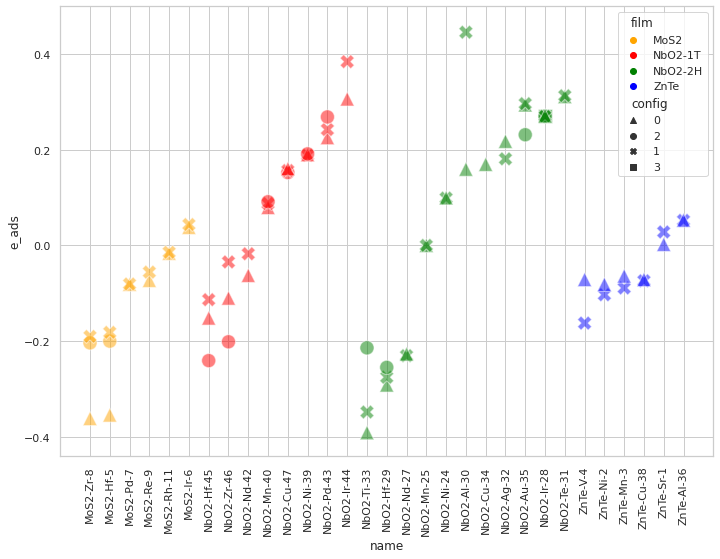

In [4]:
# adsorption formation energy: 111
sns.set(style="whitegrid", rc={'figure.figsize':(11.7,8.27)})
ads_111 = ads_energy[ads_energy.surf == '111']
ads = ads_111.sort_values(by=['film','e_ads'])
ax = sns.scatterplot(x="name", y="e_ads", data=ads, hue='film', 
                     style='config', s=200, markers=['^','o','X','s'], alpha=0.5, 
                     palette=['orange','red','green','blue'])
ax.set(ylim=(round(min(ads.e_ads),2)-0.05,round(max(ads.e_ads),2)+0.05))
plt.xticks(rotation=90)
fig = ax.get_figure()

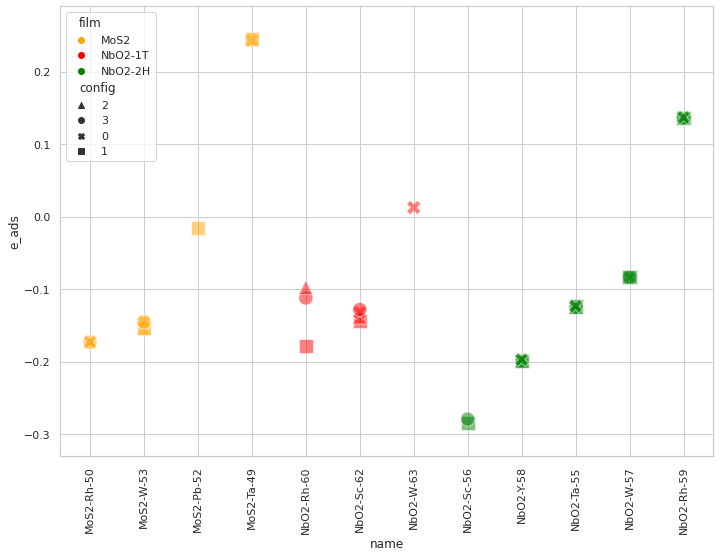

In [5]:
# adsorption formation energy: 011
ads_011 = ads_energy[ads_energy.surf == '011']
ads = ads_011.sort_values(by=['film','e_ads'])
ax = sns.scatterplot(x="name", y="e_ads", data=ads, hue='film', 
                     style='config', s=200, markers=['^','o','X','s'], alpha=0.5, 
                     palette=['orange','red','green'])
ax.set(ylim=(round(min(ads.e_ads),2)-0.05,round(max(ads.e_ads),2)+0.05))
plt.xticks(rotation=90)
fig = ax.get_figure()